# Mapping Chemical Space with UMAP
This notebook walks you through creating a 2D visualization of a chemical dataset with UMAP, using the Blood Brain Barrier Permeability (BBBP) dataset from [MoleculeNet](http://moleculenet.ai/datasets-1). We show you how to install the relevant packages, embed your smiles as [ECFPs](https://pubs.acs.org/doi/10.1021/ci100050t), then reduce those high-dimensional vectors down to 2 dimensions with both Dataset-Specific and Dataset-Agnostic embeddings. We also include PCA and T-SNE embeddings for comparison.  

Clustering using UMAP is an example of **unsupervised** machine learning.


# Imports & Utils

In [ ]:
from typing import List

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem.rdchem import Mol
from rdkit.Chem.MolStandardize.rdMolStandardize import LargestFragmentChooser

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import hdbscan

In [82]:
# Silence non-critical RDKit warnings to minimize unnecessary outputs
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

In [83]:
def get_largest_fragment_from_smiles(s: str):
    mol = Chem.MolFromSmiles(s)
    if mol:
        clean_mol = LargestFragmentChooser().choose(mol)
        return Chem.MolToSmiles(clean_mol)
    return None

def compute_ecfp_descriptors(smiles_list: List[str]):
    """ Computes ecfp descriptors """

    keep_idx = []
    descriptors = []
    for i, smiles in enumerate(smiles_list):
        ecfp = _compute_single_ecfp_descriptor(smiles)
        if ecfp is not None:
            keep_idx.append(i)
            descriptors.append(ecfp)

    return np.vstack(descriptors), keep_idx

def _compute_single_ecfp_descriptor(smiles: str):
    try:
        mol = Chem.MolFromSmiles(smiles)
    except Exception as E:
        return None

    if mol:
        fp = Chem.AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
        return np.array(fp)

    return None

# Embed BBBP with UMAP, PCA, t-SNE (Dataset-Specific Embeddings)

### Read in and process data

In [84]:
# Read in data from MoleculeNet
bbbp = pd.read_csv("data/BBBP.csv")

# Clean up columnn names so they are easier to interpret
bbbp = bbbp[["smiles", "p_np", "name"]].reset_index(drop=True).rename({"p_np": "permeable"}, axis=1)

# Remove extra fragments in SMILES (typically salts, which are irrelevant to BBB permeability)
bbbp["smiles"] = bbbp["smiles"].apply(get_largest_fragment_from_smiles).dropna()
import pandas as pd
pd.DataFrame(bbbp).head()

,smiles,permeable,name
0,CC(C)NCC(O)COc1cccc2ccccc12,1,Propanolol
1,CC(C)(C)OC(=O)CCCc1ccc(N(CCCl)CCCl)cc1,1,Terbutylchlorambucil
2,CC1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23,1,40730
3,CC(=O)NCCCOc1cccc(CN2CCCCC2)c1,1,24
4,Cc1onc(-c2ccccc2Cl)c1C(=O)N[C@@H]1C(=O)N2[C@@H...,1,cloxacillin


### Compute ECFP Descriptors

In [85]:
# Compute desrciptors and keep track of which failed to featurize
ecfp_descriptors, keep_idx = compute_ecfp_descriptors(bbbp["smiles"])

# Only keep those that sucessfully featurized
bbbp = bbbp.iloc[keep_idx]

### Embed with UMAP

In [86]:
%%time
umap_reducer = umap.UMAP(metric = "jaccard",
                      n_neighbors = 25,
                      n_components = 2,
                      low_memory = False,
                      min_dist = 0.001)
umap_embedding = umap_reducer.fit_transform(ecfp_descriptors)
bbbp["UMAP_0"], bbbp["UMAP_1"] = umap_embedding[:,0], umap_embedding[:,1]

c:\Users\marqu\SynologyDrive\Drive\Aktivitäten\FORSCHUNG\Talk IBEC Barcelona\workshop_py\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\marqu\SynologyDrive\Drive\Aktivitäten\FORSCHUNG\Talk IBEC Barcelona\workshop_py\.venv\Lib\site-packages\umap\umap_.py:1887: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


CPU times: total: 14.7 s
Wall time: 11.4 s


In [87]:
pd.DataFrame(bbbp).head()

,smiles,permeable,name,UMAP_0,UMAP_1
0,CC(C)NCC(O)COc1cccc2ccccc12,1,Propanolol,9.922902,11.619682
1,CC(C)(C)OC(=O)CCCc1ccc(N(CCCl)CCCl)cc1,1,Terbutylchlorambucil,9.557563,12.016254
2,CC1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23,1,40730,11.135263,9.464980
3,CC(=O)NCCCOc1cccc(CN2CCCCC2)c1,1,24,9.727191,14.996291
4,Cc1onc(-c2ccccc2Cl)c1C(=O)N[C@@H]1C(=O)N2[C@@H...,1,cloxacillin,10.399854,4.325299


### Embed with PCA

In [88]:
%%time
pca = PCA(n_components=2)
X_pca = pca.fit_transform(ecfp_descriptors)
bbbp["PCA_0"], bbbp["PCA_1"] = X_pca[:,0], X_pca[:,1]

CPU times: total: 438 ms
Wall time: 133 ms


### Embed with t-SNE

In [89]:
%%time
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(ecfp_descriptors)
bbbp["TNSE_0"], bbbp["TNSE_1"] = X_tsne[:,0], X_tsne[:,1]

CPU times: total: 47.9 s
Wall time: 5.3 s


### Visualize the dataset embeddedings

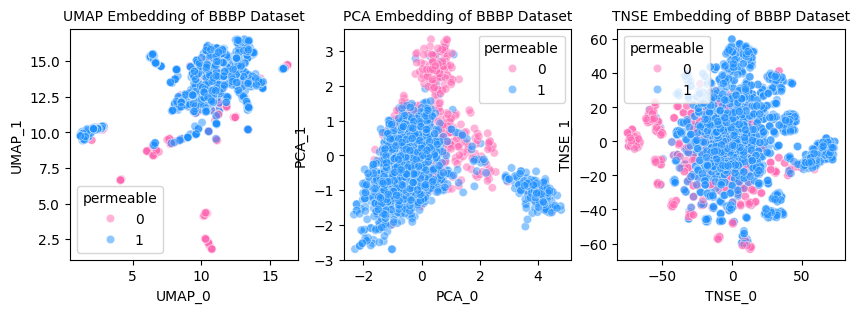

In [90]:
palette = sns.color_palette(["hotpink", "dodgerblue"])
fig, ax = plt.subplots(1, 3, figsize=(10,3))
for i, method in enumerate(["UMAP", "PCA", "TNSE"]):
    sns.scatterplot(data=bbbp,
                    x=f"{method}_0",
                    y=f"{method}_1",
                    hue="permeable",
                    alpha=0.5,
                    palette=palette,
                    ax=ax[i])
    ax[i].set_title(f"{method} Embedding of BBBP Dataset", fontsize=10)
# for method in ["UMAP", "PCA", "TNSE"]:
#     plt.figure(figsize=(8,8))
#     sns.scatterplot(data=bbbp,
#                     x=f"{method}_0",
#                     y=f"{method}_1",
#                     hue="permeable",
#                     alpha=0.5,
#                     palette=palette)
#     plt.title(f"{method} Embedding of BBBP Dataset")
#     plt.show()

In [99]:
# Read in data from MoleculeNet
chembl = pd.read_csv("https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/chembl_sparse.csv.gz", compression='gzip')

# Sample a random 10k
chembl_sample = chembl.sample(n=10000)

pd.DataFrame(chembl_sample).head()

,smiles,CHEMBL1075051,CHEMBL1075104,CHEMBL1075145,CHEMBL1075189,CHEMBL1075228,CHEMBL1075284,CHEMBL1075319,CHEMBL1163101,CHEMBL1163116,...,CHEMBL6084,CHEMBL6136,CHEMBL6137,CHEMBL6140,CHEMBL6141,CHEMBL6145,CHEMBL6154,CHEMBL6164,CHEMBL6166,CHEMBL6184
165336,CN(C)C(=O)c1cc(cc2c3CNCCc3oc12)S(=O)(=O)c4ccccc4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33432,COc1nc(nc(C)c1F)N2C[C@H]3C(=O)N(C)C(=N[C@]3(C2...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56764,CN(C)c1ccc(cc1)S(=O)(=O)NC(=O)N2CCC(CC2)N3CCC(...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
187418,CN[C@@H]1CCN(C1)c2cc(CCl)nc(N)n2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37626,CCCCCOC(=O)N1CCN(CC1)C(=O)[C@H](CCC(=O)O)NC(=O...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [93]:
%%time
# Compute desrciptors and keep track of which failed to featurize
chembl_ecfp_descriptors, chembl_keep_idx = compute_ecfp_descriptors(chembl_sample["smiles"])

# Only keep those that sucessfully featurized
chembl_sample = chembl_sample.iloc[chembl_keep_idx]

CPU times: total: 12.5 s
Wall time: 13.5 s


In [94]:
%%time
umap_model_global = umap.UMAP(metric = "jaccard",
                               n_neighbors = 25,
                               n_components = 2,
                               low_memory = False,
                               min_dist = 0.001)
X_umap_global = umap_model_global.fit_transform(chembl_ecfp_descriptors)
chembl_sample["UMAP_0"], chembl_sample["UMAP_1"] = X_umap_global[:,0], X_umap_global[:,1]

c:\Users\marqu\SynologyDrive\Drive\Aktivitäten\FORSCHUNG\Talk IBEC Barcelona\workshop_py\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\marqu\SynologyDrive\Drive\Aktivitäten\FORSCHUNG\Talk IBEC Barcelona\workshop_py\.venv\Lib\site-packages\umap\umap_.py:1887: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


CPU times: total: 51.3 s
Wall time: 7.57 s


In [95]:
%%time
X_umap_bbbp = umap_model_global.transform(ecfp_descriptors)
bbbp["UMAP_0 (global)"], bbbp["UMAP_1 (global)"] = X_umap_bbbp[:,0], X_umap_bbbp[:,1]

c:\Users\marqu\SynologyDrive\Drive\Aktivitäten\FORSCHUNG\Talk IBEC Barcelona\workshop_py\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CPU times: total: 11.6 s
Wall time: 9.98 s


In [96]:
pd.DataFrame(bbbp).head()

,smiles,permeable,name,UMAP_0,UMAP_1,PCA_0,PCA_1,TNSE_0,TNSE_1,UMAP_0 (global),UMAP_1 (global)
0,CC(C)NCC(O)COc1cccc2ccccc12,1,Propanolol,9.922902,11.619682,-0.884468,0.820288,-38.839241,-7.795067,10.908521,8.139977
1,CC(C)(C)OC(=O)CCCc1ccc(N(CCCl)CCCl)cc1,1,Terbutylchlorambucil,9.557563,12.016254,-0.141927,0.399020,-31.714970,-23.532574,10.958731,7.069962
2,CC1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23,1,40730,11.135263,9.464980,0.196504,-0.384201,-30.852793,-45.463600,11.670119,10.399192
3,CC(=O)NCCCOc1cccc(CN2CCCCC2)c1,1,24,9.727191,14.996291,-0.607434,-0.263658,-32.331242,36.833237,11.426995,9.044467
4,Cc1onc(-c2ccccc2Cl)c1C(=O)N[C@@H]1C(=O)N2[C@@H...,1,cloxacillin,10.399854,4.325299,0.121064,1.925191,-73.753654,-2.632052,9.662074,10.001107


Text(0.5, 1.0, 'Global UMAP Embedding of BBBP Dataset')

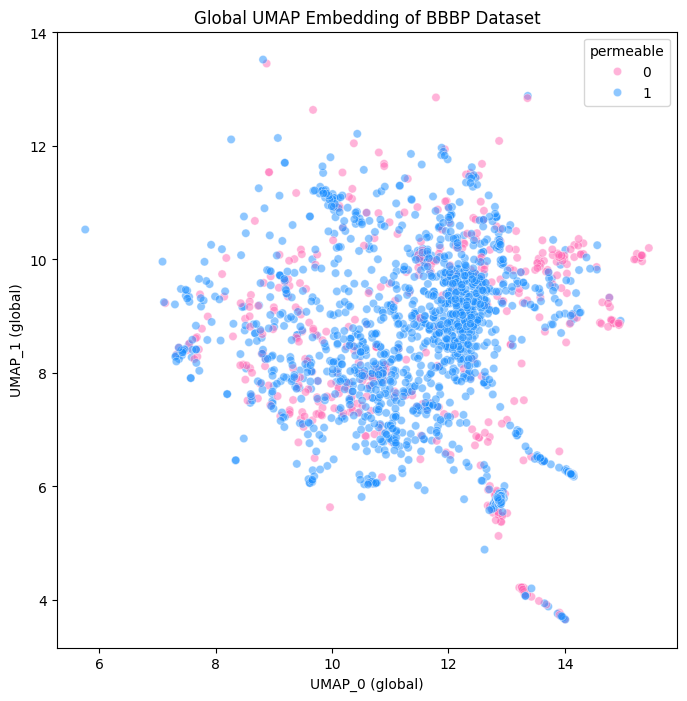

In [98]:
# visualise global umap from bbbp
plt.figure(figsize=(8,8))
sns.scatterplot(data=bbbp,
                x="UMAP_0 (global)",
                y="UMAP_1 (global)",
                hue="permeable",
                alpha=0.5,
                palette=palette)
plt.title("Global UMAP Embedding of BBBP Dataset")
